<a href="https://colab.research.google.com/github/bartolomeoadrian/computer-vision/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar librerías

In [57]:
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from PIL import ImageFont, ImageDraw, Image

# Video original

In [58]:
video_url = 'https://raw.githubusercontent.com/bartolomeoadrian/computer-vision/refs/heads/main/assets/videos/dashboard.mp4'
r = requests.get(video_url)

with open("/content/dashboard.mp4", "wb") as f:
    f.write(r.content)

# Función auxiliar para dibujar imagenes

In [59]:
def show_images(images, rows=1, cols=2, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    for i, (title, img) in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray" if img.ndim==2 else None)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Imagen para realizar pruebas

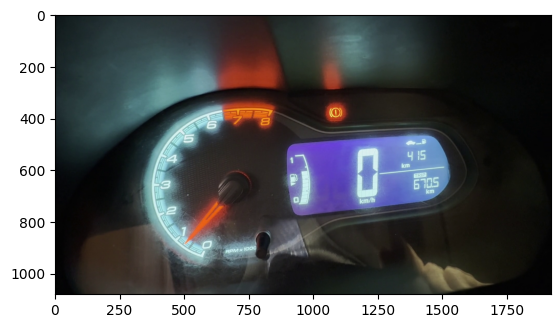

In [60]:
cap = cv2.VideoCapture('/content/dashboard.mp4')

cap.set(cv2.CAP_PROP_POS_MSEC, 16 * 1000)

ret, frame = cap.read()
cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_rgb)
plt.show()

# Identificar áreas a evaluar

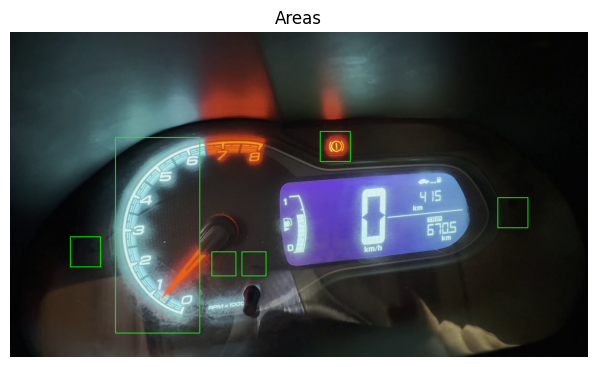

In [61]:
frame = frame_rgb.copy()

LEFT_TURN = (200, 680, 300, 780)
RIGHT_TURN = (1620, 550, 1720, 650)
HAND_BRAKE = (1030, 330, 1130, 430)
HIGH_BEAMS = (770, 730, 850, 810)
PARKING_LIGHTS = (670, 730, 750, 810)
SPEEDOMETER = (350, 350, 630, 1000)

def draw_box(frame, box, color=(0,255,0)):
    x1, y1, x2, y2 = box
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

draw_box(frame, LEFT_TURN)
draw_box(frame, RIGHT_TURN)
draw_box(frame, HAND_BRAKE)
draw_box(frame, HIGH_BEAMS)
draw_box(frame, PARKING_LIGHTS)
draw_box(frame, SPEEDOMETER)

show_images([("Areas", frame)])

# Detectar estados

In [62]:
def color_ratio(frame, box, lower, upper):
    x1, y1, x2, y2 = box
    section = frame[y1:y2, x1:x2]

    pixels = section.reshape(-1, 3)
    R = pixels[:, 0]
    G = pixels[:, 1]
    B = pixels[:, 2]

    R_low, G_low, B_low = lower
    R_up,  G_up,  B_up  = upper

    mask = (
        (R >= R_low) & (R <= R_up) &
        (G >= G_low) & (G <= G_up) &
        (B >= B_low) & (B <= B_up)
    )

    return mask.mean()

GREEN_LOW = [0, 90, 0]
GREEN_HIGH = [180, 255, 180]

BLUE_LOW = [0, 0, 120]
BLUE_HIGH = [180, 180, 255]

RED_LOW = [150, 0, 0]
RED_HIGH = [255, 100, 80]

def left_turn_on(frame, threshold=0.02):
    ratio_left = color_ratio(frame, LEFT_TURN, GREEN_LOW, GREEN_HIGH)
    ratio_right = color_ratio(frame, RIGHT_TURN, GREEN_LOW, GREEN_HIGH)
    return (
        ratio_left > threshold and
        ratio_right < threshold
    )

def right_turn_on(frame, threshold=0.02):
    ratio_right = color_ratio(frame, RIGHT_TURN, GREEN_LOW, GREEN_HIGH)
    ratio_left = color_ratio(frame, LEFT_TURN, GREEN_LOW, GREEN_HIGH)
    return (
        ratio_right > threshold and
        ratio_left < threshold
    )

def beacons_on(frame, threshold=0.02):
    ratio_right = color_ratio(frame, RIGHT_TURN, GREEN_LOW, GREEN_HIGH)
    ratio_left = color_ratio(frame, LEFT_TURN, GREEN_LOW, GREEN_HIGH)
    return (
        ratio_right > threshold and
        ratio_left > threshold
    )

def hand_brake_on(frame, threshold=0.02):
    ratio = color_ratio(frame, HAND_BRAKE, RED_LOW, RED_HIGH)
    return ratio > threshold

def parking_lights_on(frame, threshold=0.02):
    ratio = color_ratio(frame, PARKING_LIGHTS, GREEN_LOW, GREEN_HIGH)
    return ratio > threshold

def high_beams_on(frame, threshold=0.02):
    ratio = color_ratio(frame, HIGH_BEAMS, BLUE_LOW, BLUE_HIGH)
    return ratio > threshold

# Detectar revoluciones

# Dibujar estados

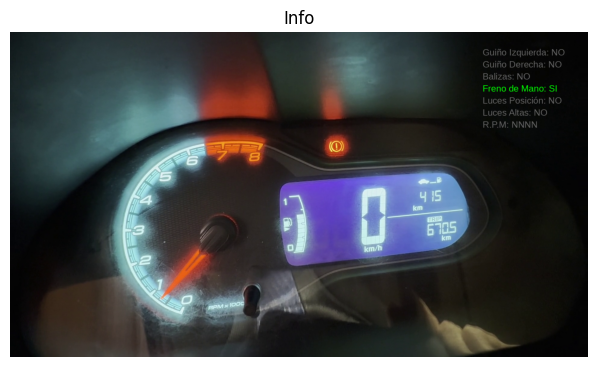

In [63]:
def draw_dashboard_info(frame):
    height, width, _ = frame.shape

    text_color_on = (0, 255, 0)
    text_color_off = (100, 100, 100)

    line_height = 40

    x_offset = width - 350
    y_offset = 50

    # Common font path in Colab environment for Unicode support
    font_path = "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"
    font_size = 30

    info_lines = []
    colors = []

    if left_turn_on(frame):
        info_lines.append("Guiño Izquierda: SI")
        colors.append(text_color_on)
    else:
        info_lines.append("Guiño Izquierda: NO")
        colors.append(text_color_off)

    if right_turn_on(frame):
        info_lines.append("Guiño Derecha: SI")
        colors.append(text_color_on)
    else:
        info_lines.append("Guiño Derecha: NO")
        colors.append(text_color_off)

    if beacons_on(frame):
        info_lines.append("Balizas: SI")
        colors.append(text_color_on)
    else:
        info_lines.append("Balizas: NO")
        colors.append(text_color_off)

    if hand_brake_on(frame):
        info_lines.append("Freno de Mano: SI")
        colors.append(text_color_on)
    else:
        info_lines.append("Freno de Mano: NO")
        colors.append(text_color_off)

    if parking_lights_on(frame):
        info_lines.append("Luces Posición: SI")
        colors.append(text_color_on)
    else:
        info_lines.append("Luces Posición: NO")
        colors.append(text_color_off)

    if high_beams_on(frame):
        info_lines.append("Luces Altas: SI")
        colors.append(text_color_on)
    else:
        info_lines.append("Luces Altas: NO")
        colors.append(text_color_off)

    info_lines.append("R.P.M: NNNN")
    colors.append(text_color_off)

    img_pil = Image.fromarray(frame)
    draw = ImageDraw.Draw(img_pil)

    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Warning: Font file not found at {font_path}. Using default Pillow font.")
        font = ImageFont.load_default()

    for i, line in enumerate(info_lines):
        y_pos = y_offset + i * line_height
        draw.text((x_offset, y_pos), line, font=font, fill=colors[i])

    modified_np_array = np.array(img_pil)

    frame[:] = modified_np_array

test_frame_for_info = frame_rgb.copy()

draw_dashboard_info(test_frame_for_info)

show_images([("Info", test_frame_for_info)])

# Generar video

In [64]:
cap = cv2.VideoCapture('/content/dashboard.mp4')

fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out = cv2.VideoWriter('/content/dashboard_final.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

with tqdm(total=total_frames, desc='Processing video') as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        final_frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        draw_dashboard_info(final_frame_rgb)

        final_frame = cv2.cvtColor(final_frame_rgb, cv2.COLOR_RGB2BGR)

        out.write(final_frame)
        pbar.update(1)

cap.release()
out.release()

Processing video: 100%|██████████| 1179/1179 [01:06<00:00, 17.76it/s]


# Resultado

[Ver acá](https://raw.githubusercontent.com/bartolomeoadrian/computer-vision/refs/heads/main/assets/videos/journey_final.mp4)